In [3]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


from rmexp import schema
%matplotlib notebook

In [22]:
exps = ['face4pool4pingpong4lego4', 'face5pool4pingpong4lego4', 'face5pool4pingpong4lego5',
        'face5pool5pingpong4lego5', 'face5pool5pingpong5lego5', 'face5pool5pingpong5lego6',
        'face5pool6pingpong6lego6', 'face5pool6pingpong6lego7', 'face5pool7pingpong6lego7',
        'face5pool7pingpong7lego7']
schemes = ['baseline', 'cpushares', ]

In [23]:
# compare total utility of different methods
total_utils = pd.DataFrame()

for scheme in schemes:
    for exp in exps:
        df = pd.read_sql(
            "select sum(utility) as utility from ExpLatency where name=%(name)s",
            schema.engine,
            params={'name': exp+'-'+scheme}
        )
        total_utils = total_utils.append({
            'exp': exp,
            'scheme': scheme,
            'total_utility': df['utility'].iat[0]
        }, ignore_index=True)
        
print(total_utils)

                         exp     scheme  total_utility
0   face4pool4pingpong4lego4   baseline    9495.794107
1   face5pool4pingpong4lego4   baseline    9674.512616
2   face5pool4pingpong4lego5   baseline    8648.864912
3   face5pool5pingpong4lego5   baseline    8565.046622
4   face5pool5pingpong5lego5   baseline    8950.159028
5   face5pool5pingpong5lego6   baseline    9078.064552
6   face5pool6pingpong6lego6   baseline    8737.138545
7   face5pool6pingpong6lego7   baseline    6392.107654
8   face5pool7pingpong6lego7   baseline    6480.628068
9   face5pool7pingpong7lego7   baseline    5845.263599
10  face4pool4pingpong4lego4  cpushares   10367.267709
11  face5pool4pingpong4lego4  cpushares   10270.428002
12  face5pool4pingpong4lego5  cpushares   11554.835350
13  face5pool5pingpong4lego5  cpushares   11422.109853
14  face5pool5pingpong5lego5  cpushares   11660.839498
15  face5pool5pingpong5lego6  cpushares   11159.604852
16  face5pool6pingpong6lego6  cpushares   11618.139932
17  face5p

<IPython.core.display.Javascript object>


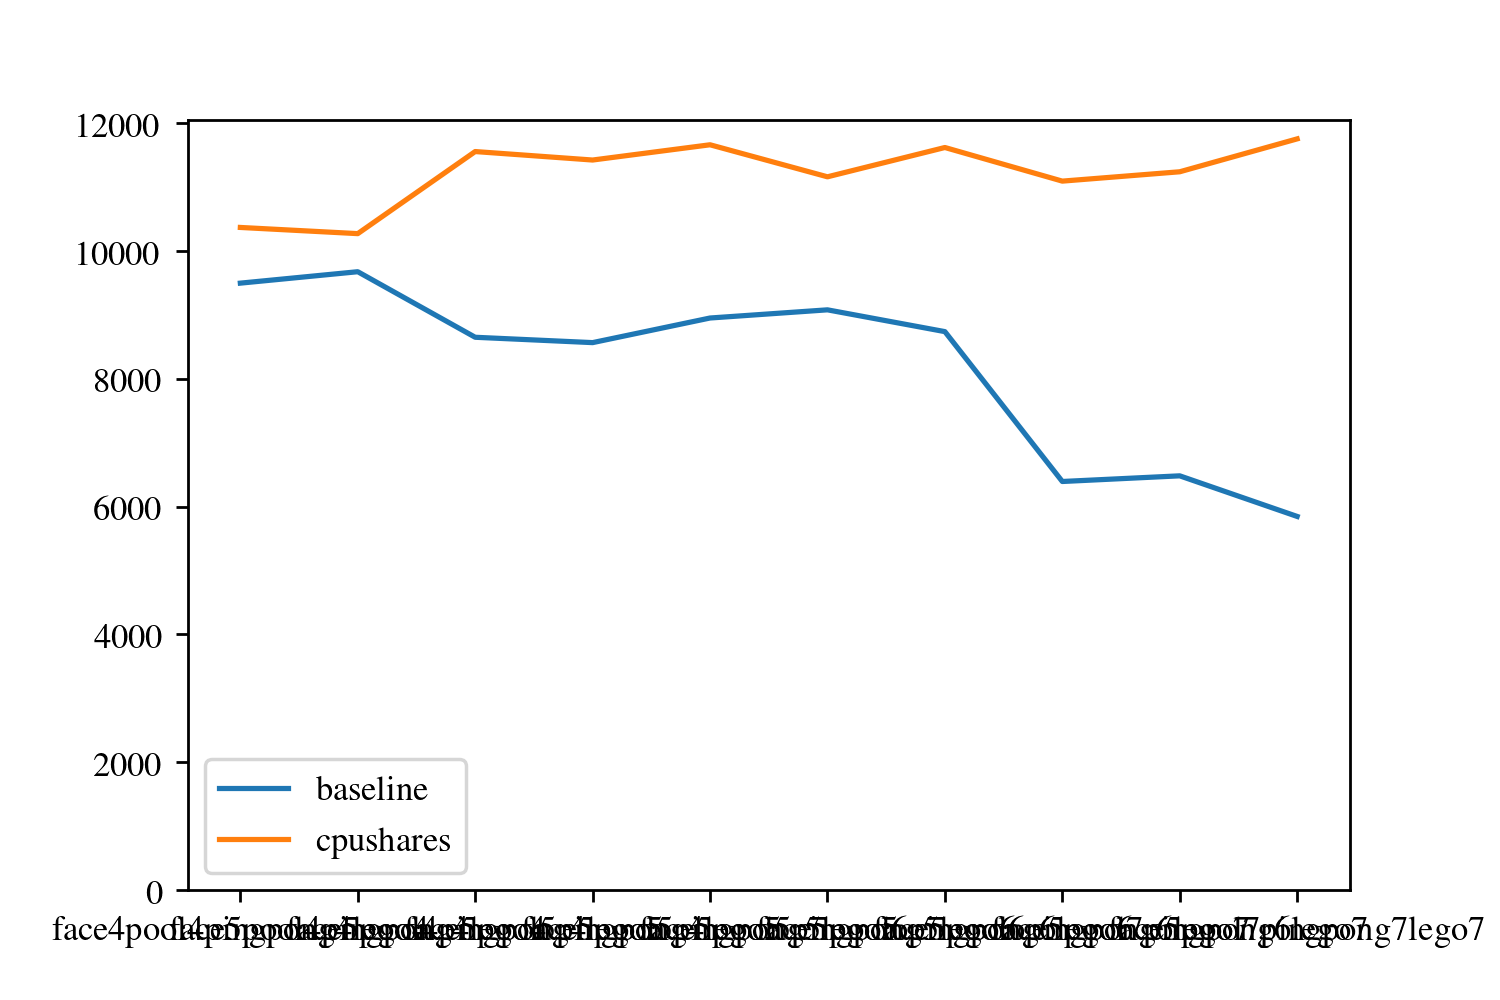

In [24]:
plt.figure(figsize=(6,4))
for scheme in schemes:
    plt.plot('exp', 'total_utility', data=total_utils[total_utils['scheme'] == scheme], label=scheme)
plt.ylim([0, None])
plt.legend()

In [ ]:
df = pd.read_sql("select * from ExpLatency", schema.engine).drop(['id', 'date'], axis=1)
df['per_frame_util'] = df.apply(
    lambda r: app_default_utility_func[r['app']](r['reply']),
    axis=1
)
df['index_int'] = df['index'].astype(int)
df.head(5)

In [ ]:
util_summary = df.groupby(['name', 'app']).agg('mean')
util_summary.head(30)

In [ ]:
baseline_total_utilities = []
ours_total_utilities = []
experiments = ['face1', 'face1pool1', 'face1pool1pingpong1', 'face1pool1pingpong1lego1']
apps = ['lego', 'pingpong', 'face', 'pool']

BASELINE = 0
OURS = 1

utilities = {
    app: {
        experiment: [0, 0]
        for experiment in experiments
    }
    for app in apps
}

for experiment in experiments:
    baseline_df = df.loc[df['name'] == '{}-baseline'.format(experiment)]
    ours_df = df.loc[df['name'] == '{}-greedyratio'.format(experiment)]
    
    baseline_total_utility = 0
    ours_total_utility = 0
    
    for app in apps:
        baseline_app_df = baseline_df.loc[baseline_df.app == app]
        ours_app_df = ours_df.loc[ours_df.app == app]
    
        if (baseline_app_df.shape[0] > 0 and ours_app_df.shape[0] > 0):
            max_index_baseline_app = baseline_app_df.index_int.max()
            max_index_ours_app = ours_app_df.index_int.max()
            max_index_app = min(max_index_baseline_app, max_index_ours_app)

            valid_baseline_app_df = baseline_app_df[baseline_app_df.index_int < max_index_app]
            valid_ours_app_df = ours_app_df[ours_app_df.index_int < max_index_app]

            baseline_app_utility = valid_baseline_app_df.per_frame_util.sum()
            ours_app_utility = valid_ours_app_df.per_frame_util.sum()
        else:
            baseline_app_utility = 0
            ours_app_utility = 0
    
        utilities[app][experiment][BASELINE] = baseline_app_utility
        utilities[app][experiment][OURS] = ours_app_utility
        
        baseline_total_utility += baseline_app_utility
        ours_total_utility += ours_app_utility
    
    baseline_total_utilities.append(baseline_total_utility)
    ours_total_utilities.append(ours_total_utility)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

AXIS_TITLES = ['E1', 'E2', 'E3', 'E4']

print(baseline_total_utilities)
print(ours_total_utilities)
ax1.scatter(AXIS_TITLES, baseline_total_utilities, color='k', marker='o', label='baseline')
ax1.scatter(AXIS_TITLES, ours_total_utilities, color='k', marker='*', label='ours')
ax1.set_ylim(ymin=0)
plt.legend(loc='upper left')
plt.show()
plt.savefig('total-utilities.pdf', bbox_inches='tight')

In [ ]:
for experiment in experiments:
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.bar([0, 1], utilities['lego'][experiment], width=0.2, color='w', edgecolor='k', hatch='/', align='center', label='lego')
    ax.bar([0.2, 1.2], utilities['face'][experiment], width=0.2, color='k', edgecolor='w', align='center', label='face')
    ax.bar([0.4, 1.4], utilities['pool'][experiment], width=0.2, color='w', edgecolor='k', hatch='.', align='center', label='pool')
    ax.bar([0.6, 1.6], utilities['pingpong'][experiment], width=0.2, color='w', edgecolor='k', hatch='\\', align='center', label='pingpong')
    
    # https://stackoverflow.com/a/35322778/859277
    ax.annotate('Baseline', xy=(0.24, 1.00), xytext=(0.24, 1.05), xycoords='axes fraction', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=1.5', lw=2.0))
    ax.annotate('Ours', xy=(0.75, 1.00), xytext=(0.75, 1.05), xycoords='axes fraction', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=1.5', lw=2.0))
    ax.axes.get_xaxis().set_visible(False)

    plt.legend()
    plt.show()
    plt.savefig('utility-{}.pdf'.format(experiment), bbox_inches='tight')

In [ ]:
df.loc[df['app'] == 'pool'].per_frame_util.sum()

In [ ]:
df.loc[(df['name'] == 'lego1pingpong1face1-ours') & (df['app'] == 'lego')].per_frame_util.sum()

In [ ]:
for experiment in experiments:
    baseline_df = df.loc[df['name'] == '{}-baseline'.format(experiment)]
    ours_df = df.loc[df['name'] == '{}-ours'.format(experiment)]    
    for app in apps:
        proccessed_baseline = 0
        skipped_baseline = 0        
        
        proccessed_ours = 0
        skipped_ours = 0
        
        baseline_app_df = baseline_df.loc[baseline_df.app == app]
        ours_app_df = ours_df.loc[ours_df.app == app]        
        
        if (baseline_app_df.shape[0] > 0 and ours_app_df.shape[0] > 0):
            max_index_baseline_app = baseline_app_df.index_int.max()
            max_index_ours_app = ours_app_df.index_int.max()
            max_index_app = min(max_index_baseline_app, max_index_ours_app)
            
            max_index_baseline_app_index_values = baseline_app_df.index_int.values
            max_index_ours_app_index_values = ours_app_df.index_int.values

            for i in xrange(max_index_app):
                if i in max_index_baseline_app_index_values:
                    proccessed_baseline += 1
                else:
                    skipped_baseline += 1
                    
                if i in max_index_ours_app_index_values:
                    proccessed_ours += 1
                else:
                    skipped_ours += 1
            print experiment, app, 'baseline'
            print 'processed:', proccessed_baseline, 'skipped:', skipped_baseline
            print ''
            print experiment, app, 'ours'
            print 'processed:', proccessed_ours, 'skipped:', skipped_ours
            print ''

In [ ]:
utilities['pool']['lego2pingpong2face2pool2']